## Data Load and Setup

In [119]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path("../data/german_credit_cleaned.csv")
df = pd.read_csv(DATA_PATH)
df.shape

(1000, 21)

## Exploratory Data Analysis (EDA)

In [120]:
# Check the balance between "good" and "bad" credit
df["target"].value_counts(normalize=True)

target
good    0.7
bad     0.3
Name: proportion, dtype: float64

In [121]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
loan_amt,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
installment_rate,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
present_residence_since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
num_curr_loans,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
num_people_provide_maint,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


In [122]:
# Check for missing values across all columns
df.isnull().sum().sort_values(ascending=False)

checking_acc_status         0
property                    0
is_foreign_worker           0
telephone                   0
num_people_provide_maint    0
job                         0
num_curr_loans              0
housing                     0
other_installment_plans     0
age                         0
present_residence_since     0
duration                    0
other_debtors_guarantors    0
personal_stat_gender        0
installment_rate            0
present_employment_since    0
saving_acc_bonds            0
loan_amt                    0
purpose                     0
cred_hist                   0
target                      0
dtype: int64

In [123]:
# Identify numeric and categorical features
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(exclude=["number"]).columns.tolist()

len(num_cols), len(cat_cols), num_cols[:5], cat_cols[:5]

(7,
 14,
 ['duration',
  'loan_amt',
  'installment_rate',
  'present_residence_since',
  'age'],
 ['checking_acc_status',
  'cred_hist',
  'purpose',
  'saving_acc_bonds',
  'present_employment_since'])

In [124]:
# Count unique values in each categorical column
df[cat_cols].nunique().sort_values()

telephone                    2
is_foreign_worker            2
target                       2
other_debtors_guarantors     3
other_installment_plans      3
housing                      3
checking_acc_status          4
personal_stat_gender         4
property                     4
job                          4
cred_hist                    5
saving_acc_bonds             5
present_employment_since     5
purpose                     10
dtype: int64

In [125]:
## Feature Engineering & Data Preparation

In [126]:
# Separate numeric categorical vs continuous numeric features
u = df.nunique()
numeric_categorical = [c for c in num_cols if u[c] <= 10]
numeric_continuous = [c for c in num_cols if u[c] > 10]

numeric_categorical, numeric_continuous

(['installment_rate',
  'present_residence_since',
  'num_curr_loans',
  'num_people_provide_maint'],
 ['duration', 'loan_amt', 'age'])

In [127]:
# Inspect values of a numeric categorical feature
df["installment_rate"].unique()

array([4, 2, 3, 1])

In [128]:
# Convert numeric categorical features to category dtype (for clarity)
for c in numeric_categorical:
    df[c] = df[c].astype("category")

df[numeric_categorical].dtypes

installment_rate            category
present_residence_since     category
num_curr_loans              category
num_people_provide_maint    category
dtype: object

In [129]:
cat_cols

['checking_acc_status',
 'cred_hist',
 'purpose',
 'saving_acc_bonds',
 'present_employment_since',
 'personal_stat_gender',
 'other_debtors_guarantors',
 'property',
 'other_installment_plans',
 'housing',
 'job',
 'telephone',
 'is_foreign_worker',
 'target']

In [130]:
# Remove target from categorical features and check unique category counts
cat_cols = [c for c in cat_cols if c != "target"]

df[cat_cols].nunique().sort_values()

telephone                    2
is_foreign_worker            2
other_debtors_guarantors     3
other_installment_plans      3
housing                      3
checking_acc_status          4
personal_stat_gender         4
property                     4
job                          4
cred_hist                    5
saving_acc_bonds             5
present_employment_since     5
purpose                     10
dtype: int64

In [131]:
# Inspect all categorical feature values to verify categories and spot formatting issues
for c in cat_cols:
    print(c, "→", df[c].unique())

checking_acc_status → ['below_0' 'below_200' 'no_cheking_acc' 'above:200']
cred_hist → ['risky_acc_or_curr_loan_other' 'curr_loans_paid_duly' 'delay_in_past'
 'no_loan_or_paid_duly_other' 'paid_duly_this_bank']
purpose → ['radio_tv' 'education' 'furniture_equipment' 'car_new' 'car_used'
 'business' 'domestic_applience' 'repairs' 'others' 'retraining']
saving_acc_bonds → ['unknown_no_saving_acc' 'below_100' 'below_1000' 'above_1000' 'below_500']
present_employment_since → ['above_7y' 'below_4y' 'below_7y' 'unemployed' 'below_1y']
personal_stat_gender → ['male:single' 'female:divorced_or_married' 'male:divorced'
 'male:married_or_widowed']
other_debtors_guarantors → ['none' 'guarantor' 'co_applicant']
property → ['real_estate' 'life_insurance_or_aggreements' 'unknown_or_no_property'
 'car_or_other']
other_installment_plans → ['none' 'bank' 'store']
housing → ['own' 'for_free' 'rent']
job → ['skilled_official' 'unskilled_resident' 'management_or_self_emp'
 'unemployed_non_resident']
telep

In [132]:
# Encode 'checking_acc_status' as ordered categories (higher = better financial standing)
checking_map = {"no_cheking_acc": 0, "below_0": 1, "below_200": 2, "above:200": 3}

df["checking_acc_status"] = df["checking_acc_status"].map(checking_map)

In [133]:
df["saving_acc_bonds"].unique()

array(['unknown_no_saving_acc', 'below_100', 'below_1000', 'above_1000',
       'below_500'], dtype=object)

In [134]:
# Encode 'saving_acc_bonds' (higher = more savings)
saving_map = {
    "unknown_no_saving_acc": 0,
    "below_100": 1,
    "below_500": 2,
    "below_1000": 3,
    "above_1000": 4,
}
df["saving_acc_bonds"] = df["saving_acc_bonds"].map(saving_map)
df["saving_acc_bonds"].unique()

array([0, 1, 3, 4, 2])

In [135]:
df["present_employment_since"].unique()

array(['above_7y', 'below_4y', 'below_7y', 'unemployed', 'below_1y'],
      dtype=object)

In [136]:
# Encode 'present_employment_since' (higher = longer employment stability)
employment_map = {
    "unemployed": 0,
    "below_1y": 1,
    "below_4y": 2,
    "below_7y": 3,
    "above_7y": 4,
}
df["present_employment_since"] = df["present_employment_since"].map(employment_map)
df["present_employment_since"].unique()

array([4, 2, 3, 0, 1])

In [137]:
df["personal_stat_gender"].unique()

array(['male:single', 'female:divorced_or_married', 'male:divorced',
       'male:married_or_widowed'], dtype=object)

In [138]:
# Split 'personal_stat_gender' into 'gender' and 'personal_status'
df[["gender", "personal_status"]] = df["personal_stat_gender"].str.split(
    ":", expand=True
)

df[["gender", "personal_status"]].head()

,gender,personal_status
0,male,single
1,female,divorced_or_married
2,male,single
3,male,single
4,male,single


In [139]:
# Split 'personal_stat_gender' into two separate categorical features
df.drop(columns=["personal_stat_gender"], inplace=True)

df[["gender", "personal_status"]].nunique()

gender             2
personal_status    4
dtype: int64

In [140]:
# Update categorical feature list after splitting
cat_cols.remove("personal_stat_gender")
cat_cols.extend(["gender", "personal_status"])

In [141]:
# One-hot encode remaining categorical features
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

df_encoded.shape

(1000, 50)

In [142]:
# Make label numeric and verify all features are numeric
df_encoded["target"] = df["target"].map({"bad": 0, "good": 1})

df_encoded.select_dtypes(exclude=["number"]).columns.tolist()

['installment_rate',
 'present_residence_since',
 'num_curr_loans',
 'num_people_provide_maint',
 'checking_acc_status_1',
 'checking_acc_status_2',
 'checking_acc_status_3',
 'cred_hist_delay_in_past',
 'cred_hist_no_loan_or_paid_duly_other',
 'cred_hist_paid_duly_this_bank',
 'cred_hist_risky_acc_or_curr_loan_other',
 'purpose_car_new',
 'purpose_car_used',
 'purpose_domestic_applience',
 'purpose_education',
 'purpose_furniture_equipment',
 'purpose_others',
 'purpose_radio_tv',
 'purpose_repairs',
 'purpose_retraining',
 'saving_acc_bonds_1',
 'saving_acc_bonds_2',
 'saving_acc_bonds_3',
 'saving_acc_bonds_4',
 'present_employment_since_1',
 'present_employment_since_2',
 'present_employment_since_3',
 'present_employment_since_4',
 'other_debtors_guarantors_guarantor',
 'other_debtors_guarantors_none',
 'property_life_insurance_or_aggreements',
 'property_real_estate',
 'property_unknown_or_no_property',
 'other_installment_plans_none',
 'other_installment_plans_store',
 'housing_

In [143]:
# Convert ordinal categorical columns to integer for XGBoost compatibility
ordinal_cols = [
    "installment_rate",
    "present_residence_since",
    "num_curr_loans",
    "num_people_provide_maint",
]
for c in ordinal_cols:
    if c in df_encoded.columns:
        df_encoded[c] = df_encoded[c].astype(int)

df_encoded.dtypes.value_counts()

bool     42
int64     8
Name: count, dtype: int64

## Modeling

In [144]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Separate features and target
X = df_encoded.drop(columns=["target"])
y = df_encoded["target"]

# Stratified train-test split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize baseline XGBoost model
xgb_clf = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",  # binary cross-entropy; standard internal objective for classification
)

In [145]:
# Train the model
xgb_clf.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## Model Evaluation

In [146]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test set
y_pred = xgb_clf.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.53      0.56        60
           1       0.81      0.84      0.83       140

    accuracy                           0.75       200
   macro avg       0.70      0.69      0.69       200
weighted avg       0.74      0.75      0.75       200

Confusion Matrix:
 [[ 32  28]
 [ 22 118]]


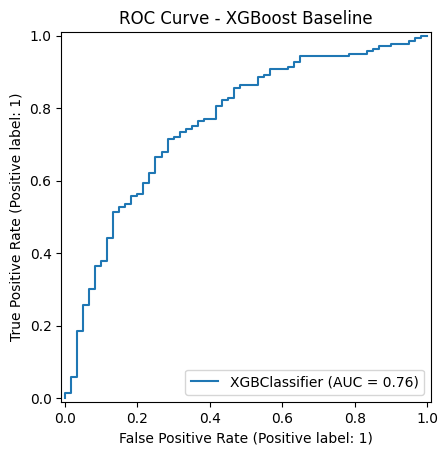

In [147]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Plot ROC curve
RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
plt.title("ROC Curve - XGBoost Baseline")
plt.show()

## Cross-Validation Baseline

In [148]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(xgb_clf, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

In [149]:
print(f"Mean ROC-AUC: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

Mean ROC-AUC: 0.763 ± 0.056


## Hyperparameter Tuning

In [150]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Reusing CV
param_dist = {
    "n_estimators": randint(300, 900),
    "max_depth": randint(3, 8),
    "learning_rate": uniform(0.02, 0.18),
    "min_child_weight": randint(1, 6),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0.0, 2.0),
}

tuned = RandomizedSearchCV(
    estimator=XGBClassifier(
        random_state=42, n_jobs=-1, eval_metric="logloss", tree_method="hist"
    ),
    param_distributions=param_dist,
    n_iter=40,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=0,
)

tuned.fit(X_train, y_train)

tuned.best_score_, tuned.best_params_


(np.float64(0.787313988095238),
 {'colsample_bytree': np.float64(0.7088528997538541),
  'gamma': np.float64(1.2953802410827246),
  'learning_rate': np.float64(0.02009366785915685),
  'max_depth': 7,
  'min_child_weight': 1,
  'n_estimators': 558,
  'subsample': np.float64(0.6027808522124762)})

In [151]:
# Hyperparameters of the best model

best_params = tuned.best_params_
best_params

{'colsample_bytree': np.float64(0.7088528997538541),
 'gamma': np.float64(1.2953802410827246),
 'learning_rate': np.float64(0.02009366785915685),
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 558,
 'subsample': np.float64(0.6027808522124762)}

In [155]:
# Train final model with best hyperparameters
xgb_best = XGBClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    tree_method="hist"
)

xgb_best.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,np.float64(0.7088528997538541)
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## Evaluate Tuned Model

In [158]:
from sklearn.metrics import roc_auc_score

# Evaluate tuned model on test set
y_pred_best  = xgb_best.predict(X_test)
y_proba_best = xgb_best.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_proba_best):.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Accuracy: 0.735
ROC-AUC:  0.754

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.42      0.49        60
           1       0.78      0.87      0.82       140

    accuracy                           0.73       200
   macro avg       0.68      0.64      0.65       200
weighted avg       0.72      0.73      0.72       200


Confusion Matrix:
 [[ 25  35]
 [ 18 122]]
